In [1]:
import numpy
import numpy as np
import numpy.matlib
import os
import cv2
import matplotlib.pyplot as plt
import scipy.io as scio
import math
import pandas

In [10]:
img_path = ""
mask_path = ""
format_name = ""
meanshape_path = ''

bd = 60 # 法向量长度

In [5]:
img_file_list = os.listdir(img_path)
img_name_list = []
img_list = []
mean_shape = numpy.transpose(scio.loadmat(meanshape_path)['MeanShape'], numpy.newaxis)
MeanShape = numpy.zeros([2,100])
MeanShape[0, :] = mean_shape[0,:100]
MeanShape[1, :] = mean_shape[0,100:]
for fn in img_file_list:
    if fn.split('.')[1] == format_name:
        img_name_list.append(fn.split('.')[0])
        img_list.append(cv2.imread(img_path+fn, cv2.IMREAD_GRAYSCALE))
print(MeanShape.shape)
#print(img_list[0].shape)

(2, 100)


In [6]:
def cputang(x1, y1, x2, y2, x3, y3):
    a2 = (x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)
    b2 = (x3-x2)*(x3-x2)+(y3-y2)*(y3-y2)
    c2 = (x1-x3)*(x1-x3)+(y1-y3)*(y1-y3)
    a = math.sqrt(a2)
    b = math.sqrt(b2)
    # c = math.sqrt(c2)
    pos = (a2+b2-c2)/(2*a*b)
    angle = math.acos(pos)
    realangle = angle*180/math.pi
    #求出余弦值，余弦值转换为弧度值，弧度制转为角度.计算三个点组成的角形成的角度值
    return realangle

In [7]:
# 计算每个点与其相邻点之间的角度
benchmarkangle = []
# 先处理第一个点和最后一个点
benchmarkangle.append(cputang(
    MeanShape[0,99], MeanShape[1,99], 
    MeanShape[0,0], MeanShape[1,0],
    MeanShape[0,1], MeanShape[1,1]
    ))
# 循环处理中间98个点
for i in range(1,99):
    benchmarkangle.append(cputang(
    MeanShape[0,i-1], MeanShape[1,i-1], 
    MeanShape[0,i], MeanShape[1,i],
    MeanShape[0,i+1], MeanShape[1,i+1]
    ))
# 处理最后一个点
benchmarkangle.append(cputang(
    MeanShape[0,98], MeanShape[1,98], 
    MeanShape[0,99], MeanShape[1,99],
    MeanShape[0,0], MeanShape[1,0]
    ))

print(benchmarkangle)

[169.02534495002797, 173.9120091704125, 174.09617989710267, 172.76664786358143, 174.14764693155888, 179.9196052804351, 172.78138838635155, 179.10867943196266, 176.2969535651315, 176.38574956521316, 176.57422584100027, 173.59175890286193, 176.07244413044768, 175.72457065186288, 177.76104836212826, 176.20089225969332, 175.84777298208766, 176.00713885928036, 179.24607386920826, 172.7324036452636, 176.77427641244566, 177.10385727175873, 173.4187416043077, 171.059880250149, 175.34842463700403, 169.09792847761273, 171.04510963192027, 170.9478716953534, 172.60602192148656, 172.6577411369476, 174.99517087251743, 172.99513188326202, 176.29578580231757, 159.05604636083584, 170.87825101716834, 179.2183843846359, 176.5155467563921, 178.656015523339, 176.41203861263844, 176.5374293691731, 176.32160790753682, 175.43848106358675, 177.68488831399128, 179.61980734244815, 178.59924517112435, 176.34235464687578, 173.6938297926502, 179.79472459973863, 174.769103162114, 178.06484340478391, 177.462899789830

In [39]:
Tp1 = numpy.array([[1,0,90],
                   [0,1,130],
                   [0,0,1]])
Tp2 = numpy.array([[0.8, 0, 0],
                   [0, 0.75, 0],
                   [0, 0, 1]])
Tp = numpy.matmul(Tp1,Tp2)
values = numpy.ones((3,100))
values[:2,:] = MeanShape[:,:]
# print(values)
values = numpy.matmul(Tp, values)
value = values[:2,:]
# value

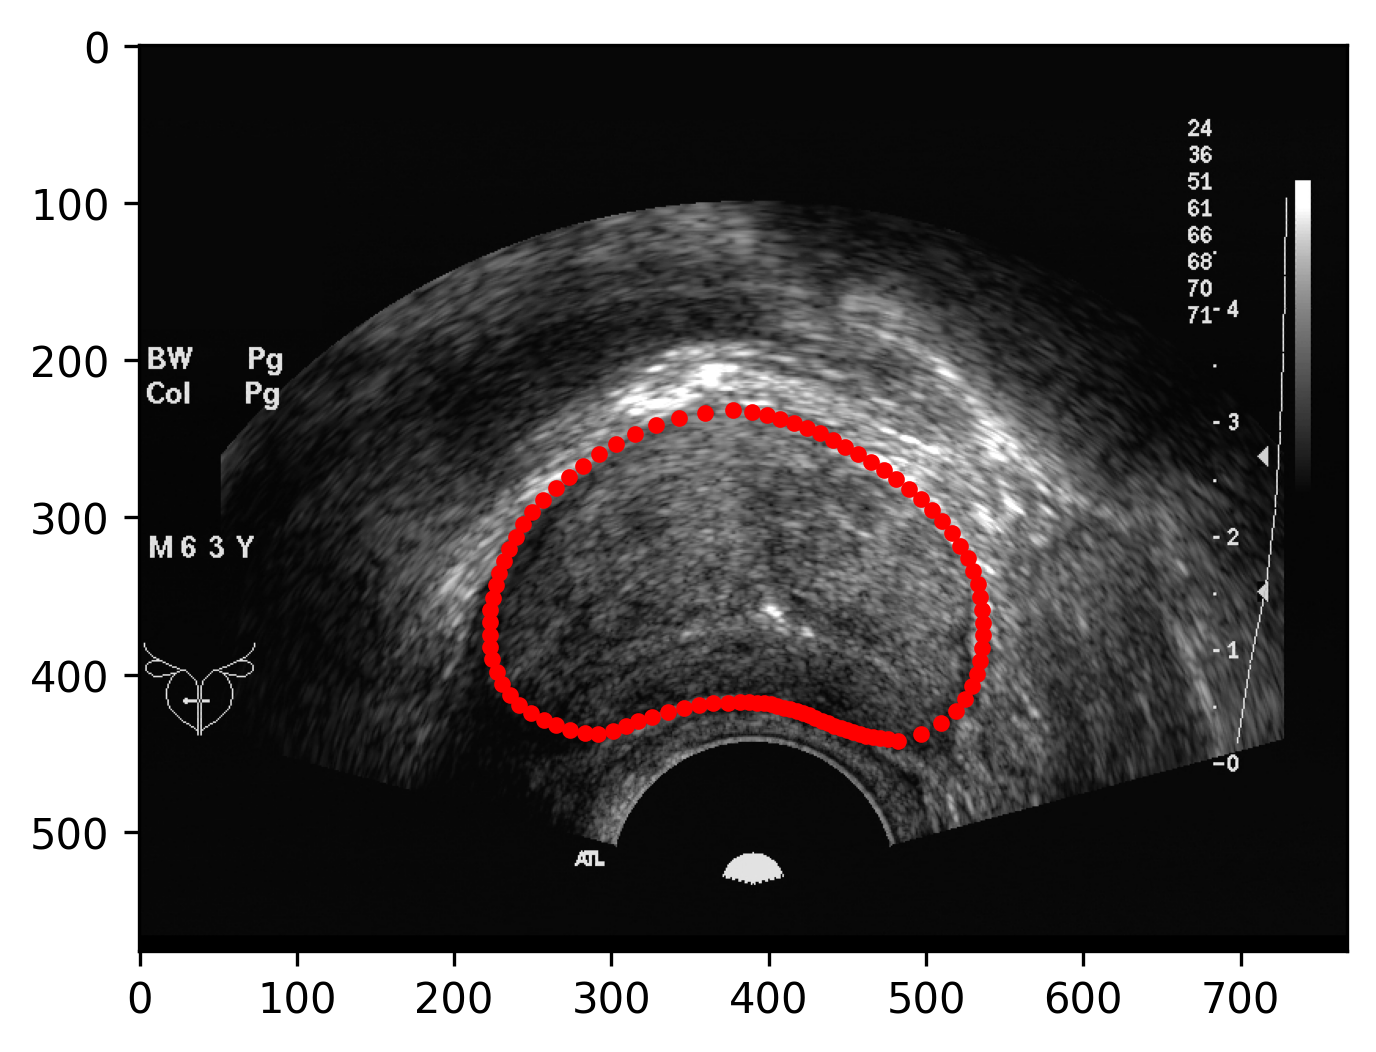

In [40]:
testimg = cv2.imread('24.bmp', cv2.IMREAD_GRAYSCALE)
plt.figure(dpi=300)
plt.imshow(testimg,cmap='gray')
plt.plot(value[0],value[1],'r.')

In [41]:
def GetContourNormals(V):
    len = V.shape[0]
    L = numpy.ones([len, 2], dtype=numpy.int8)
    for i in range(len):
        L[i, 0] = i
        L[i, 1] = i+1
    L[-1, 1] = 0

    DT = V[L[:, 0], :] - V[L[:,1], :]
    D1 = numpy.zeros(numpy.shape(V))
    D2 = numpy.zeros(numpy.shape(V))
    D1[L[:, 0], :] = DT
    D2[L[:, 1], :] = DT
    D = D1 + D2
    d1 = D[:,1]
    d0 = -D[:,0]
    L = numpy.sqrt(numpy.power(D[:,0],2)+numpy.power(D[:,1],2))
    N = D
    N[:,0] = d1/L
    N[:,1] = d0/L
    return N

In [42]:
value_t = value.transpose(1,0)
N = GetContourNormals(value_t)
# N

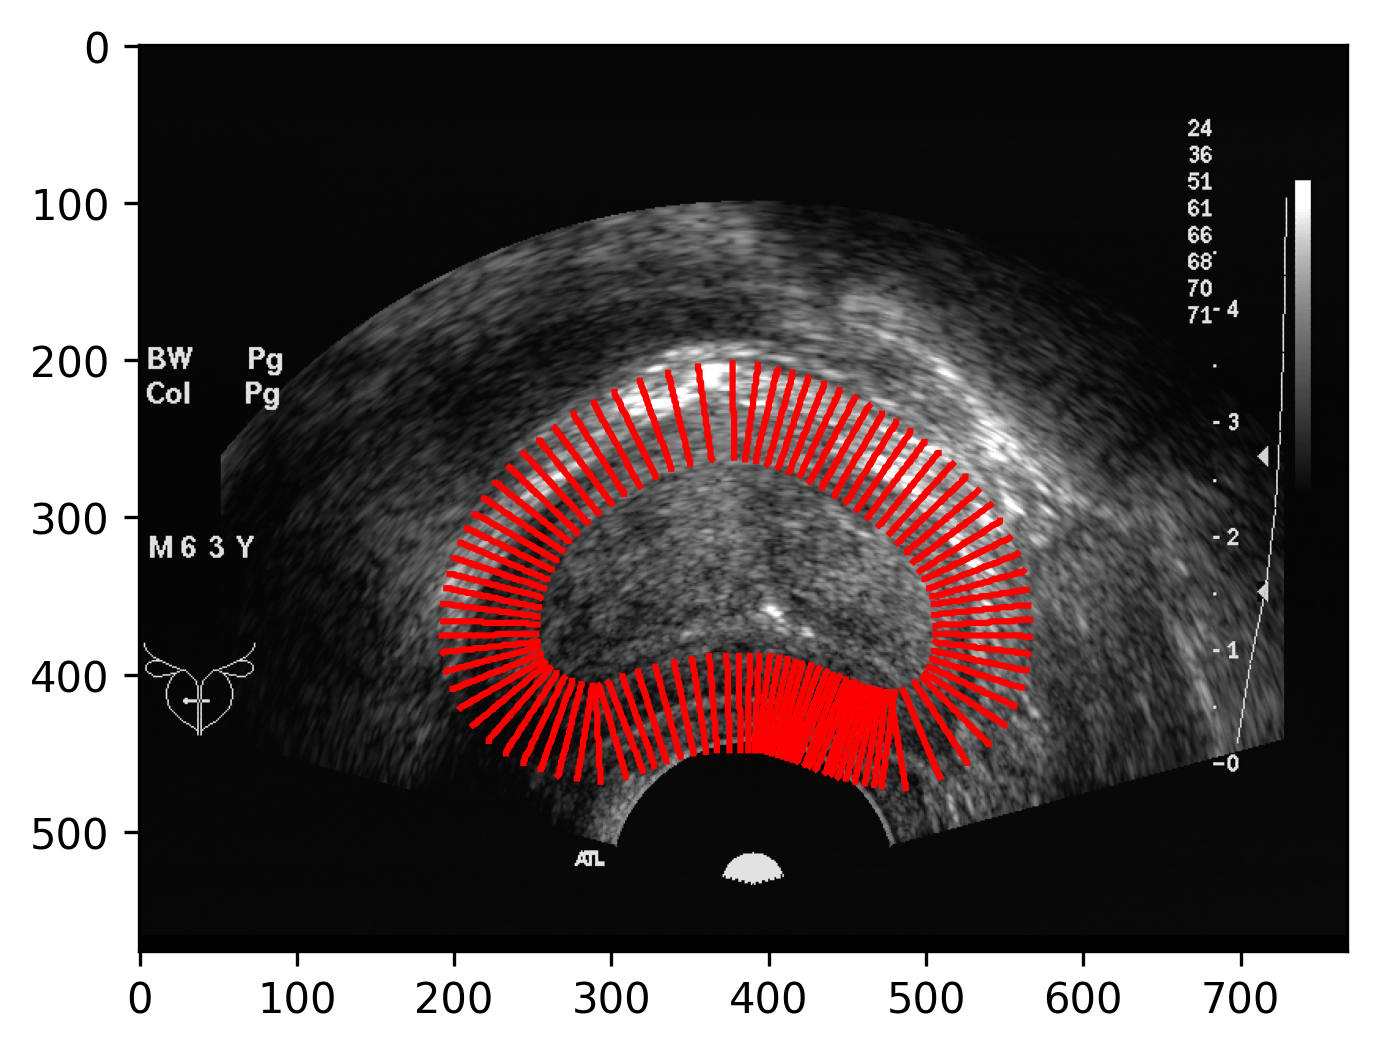

In [43]:
normpoints = []
plt.figure(dpi=300)
normVpoint = numpy.arange(bd/2, -bd/2-1, -1, dtype=numpy.int0).reshape(-1, 1)
normVpoint = numpy.repeat(normVpoint, 2, axis=1)
plt.imshow(testimg,cmap='gray')
for j in range(100):
    normalpoints = numpy.matlib.repmat(value_t[j,:],bd+1,1) + (numpy.matlib.repmat(N[j,:],bd+1,1)*normVpoint)
    normalpoints = numpy.round(normalpoints)
    plt.plot(normalpoints[:,0],normalpoints[:,1],'r-')
    normpoints.append(normalpoints)
normpoints = numpy.array(normpoints)

In [44]:
rstp = []
maxinds = []
bbb = []

l = 20

for j in range(100):
    aaa = []
    for i in range(1+l, bd+1-l):
        bbb = []
        ccc = []
        ddd = []
        eee = []
        for k in range(-1,1):
            vecNo = (j + k) % 100
            if (j+k) < 0:
                vecNo = j + k + 100
            bbb.append(normpoints[vecNo][i-l:i-1,1])
            ccc.append(normpoints[vecNo][i-l:i-1,0])
            ddd.append(normpoints[vecNo][i+1:i+l,1])
            eee.append(normpoints[vecNo][i+1:i+l,0])
        out_grayscale = testimg[numpy.array(bbb, dtype=numpy.int32),numpy.array(ccc, dtype=numpy.int32)]
        in_grayscale = testimg[numpy.array(ddd, dtype=numpy.int32),numpy.array(eee, dtype=numpy.int32)]
        outg = numpy.sum(out_grayscale, dtype=numpy.int16)
        ing = numpy.sum(in_grayscale, dtype=numpy.int16)
        aaa.append(outg - ing)
    aaa = numpy.array(aaa)
    maxv = numpy.max(aaa)
    plc = numpy.argmax(aaa)
    maxinds.append(plc)
    rstp.append(normpoints[j][plc+1+l,:])
rstp = numpy.array(rstp, dtype=numpy.int32)

(100, 61, 2)


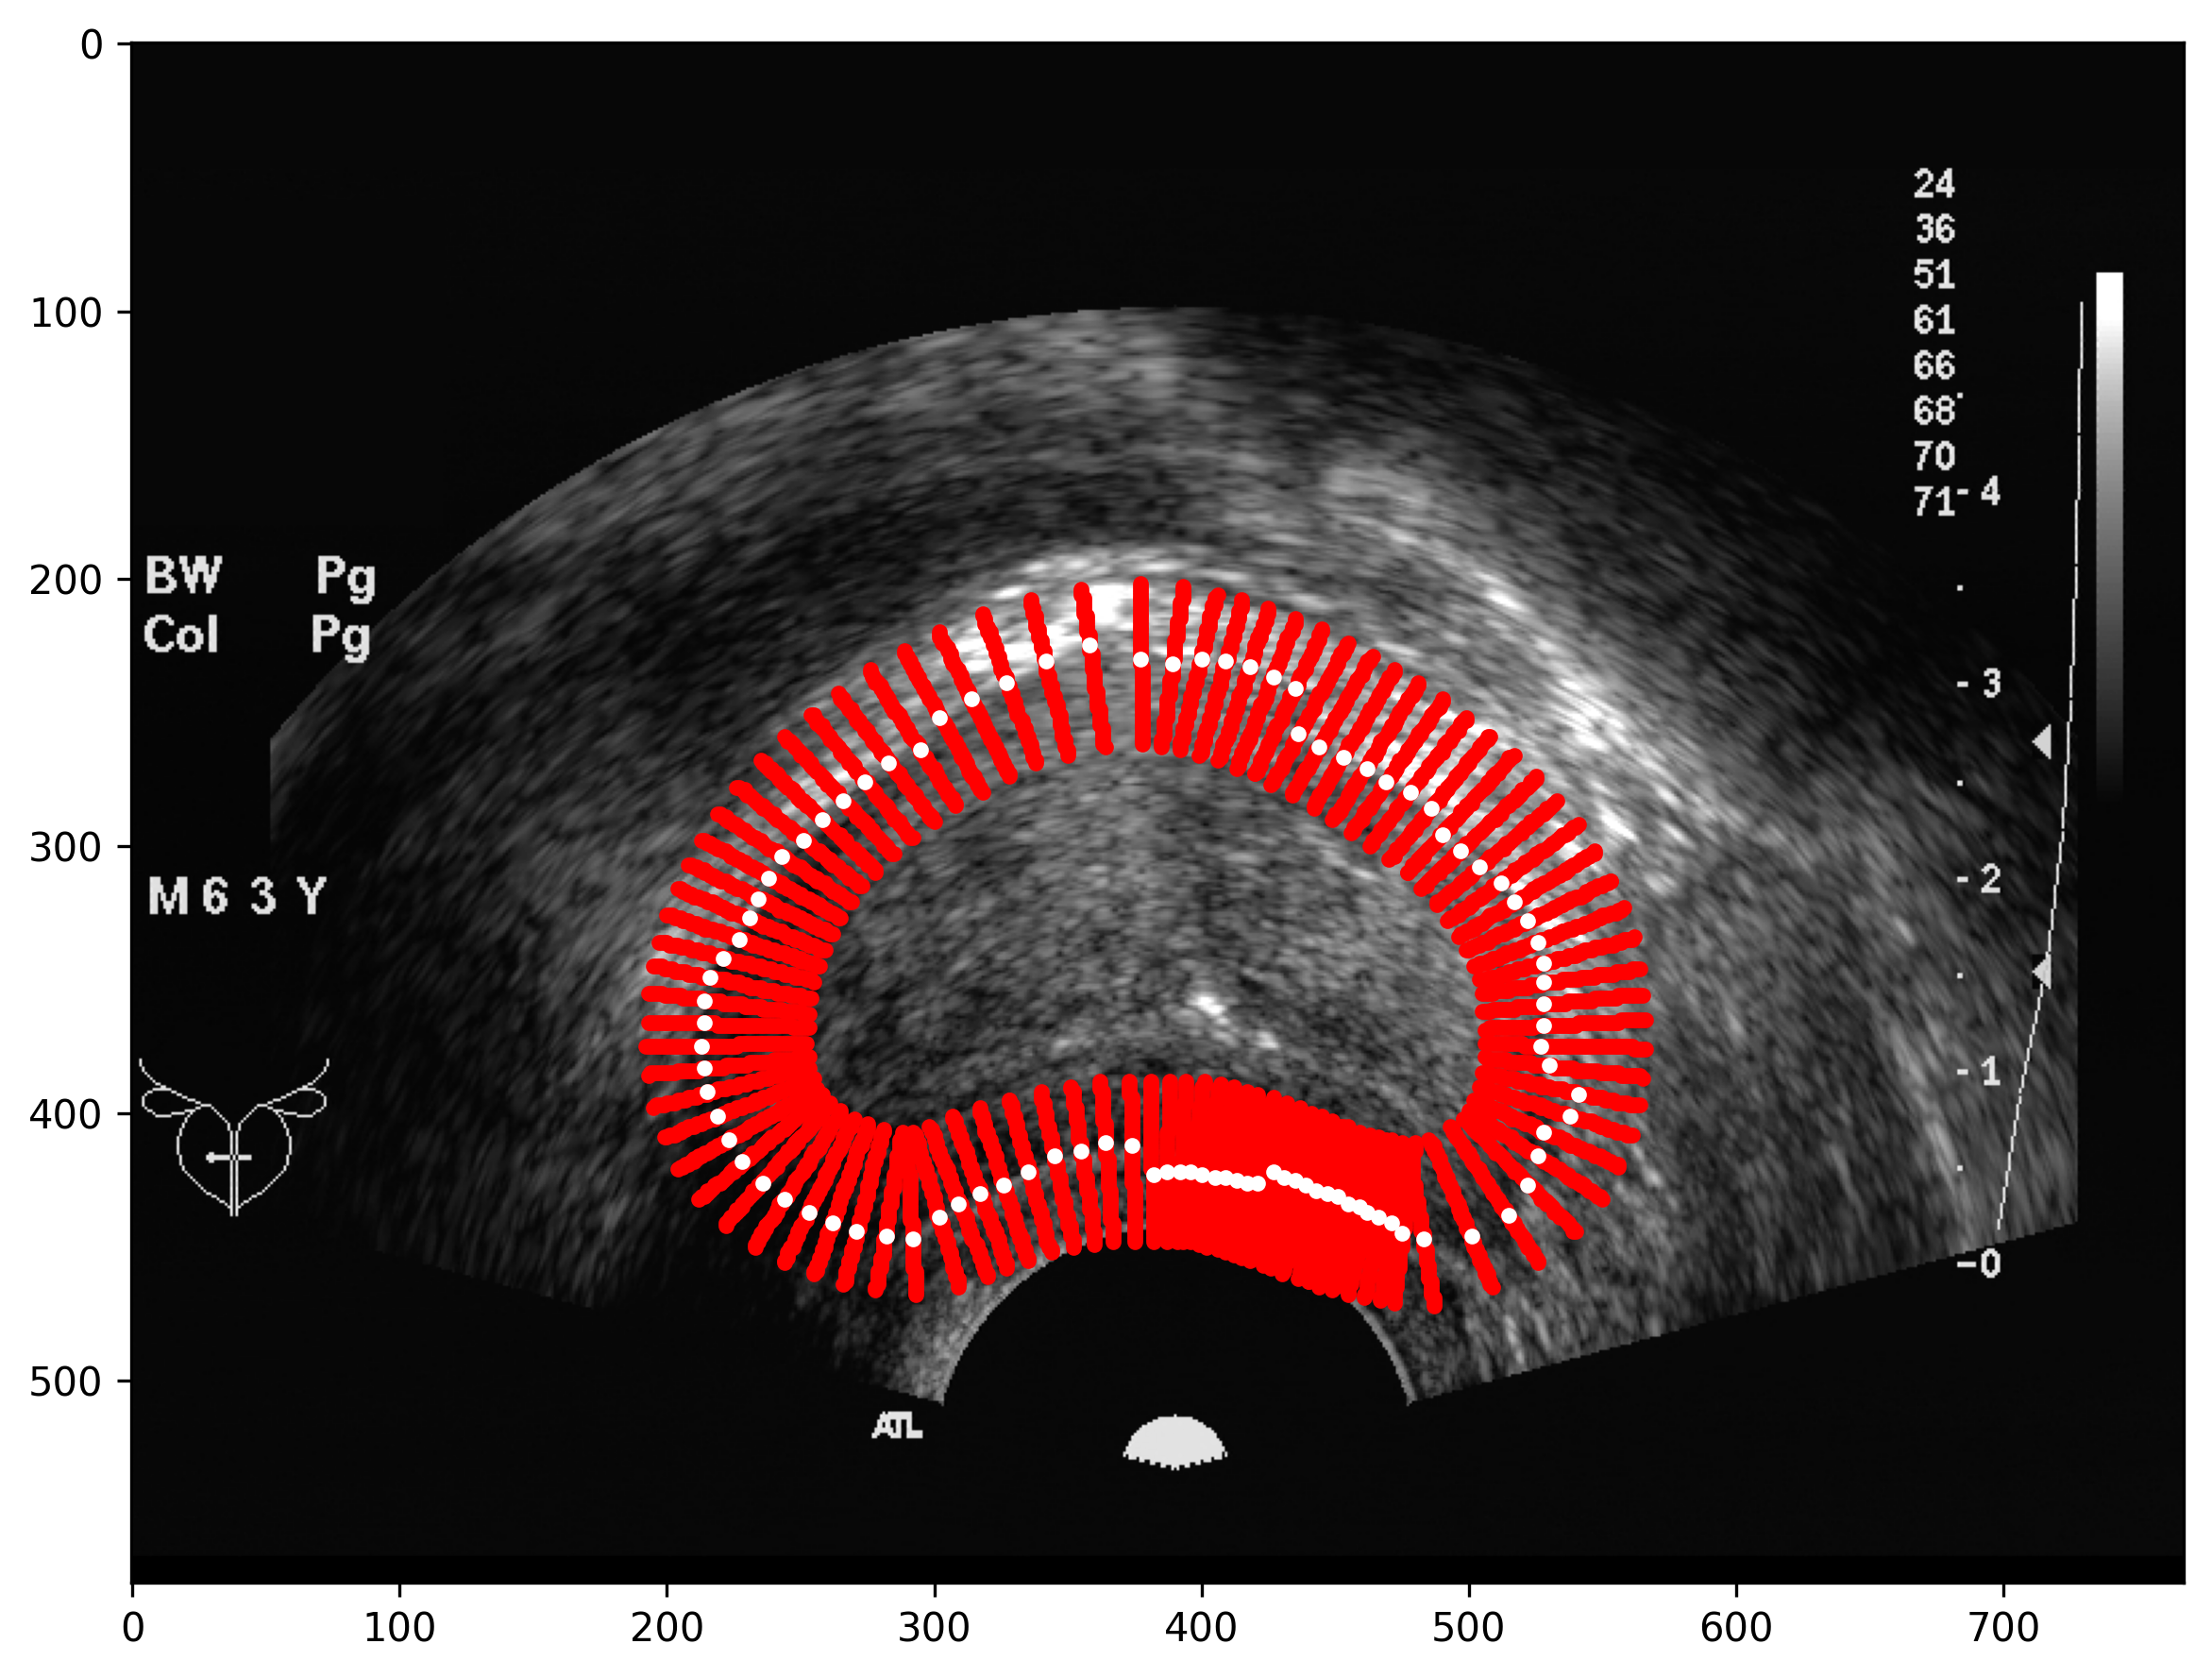

In [49]:
plt.figure(dpi=300)
plt.imshow(testimg,cmap='gray')
print(normpoints.shape)
plt.plot(normpoints[:,:,0], normpoints[:,:,1],'r.')
plt.plot(rstp[:,0], rstp[:,1],'w.')

In [50]:
#def _ema(arr):
#    N = len(arr)
#    alpha = 1 / (N+1)
#    data = numpy.zeros(len(arr))
#    for i in range(len(data)):
#        data[i] = arr[i] if i == 0 else alpha*arr[i]+(1-alpha)*data[i-1]
#    return data[-1]

#def EMA(arr, period=4):
#    data = numpy.full(arr.shape, numpy.nan)
#    for i in range(period-1, len(arr)):
#        print(data[i])
#        data[i] = _ema(arr[i+1-period:i+1])
#    return data

def EMA(arr, period=4):
    df = pandas.DataFrame(arr)
    return df.ewm(span=period, min_periods=period).mean()

(100, 2)


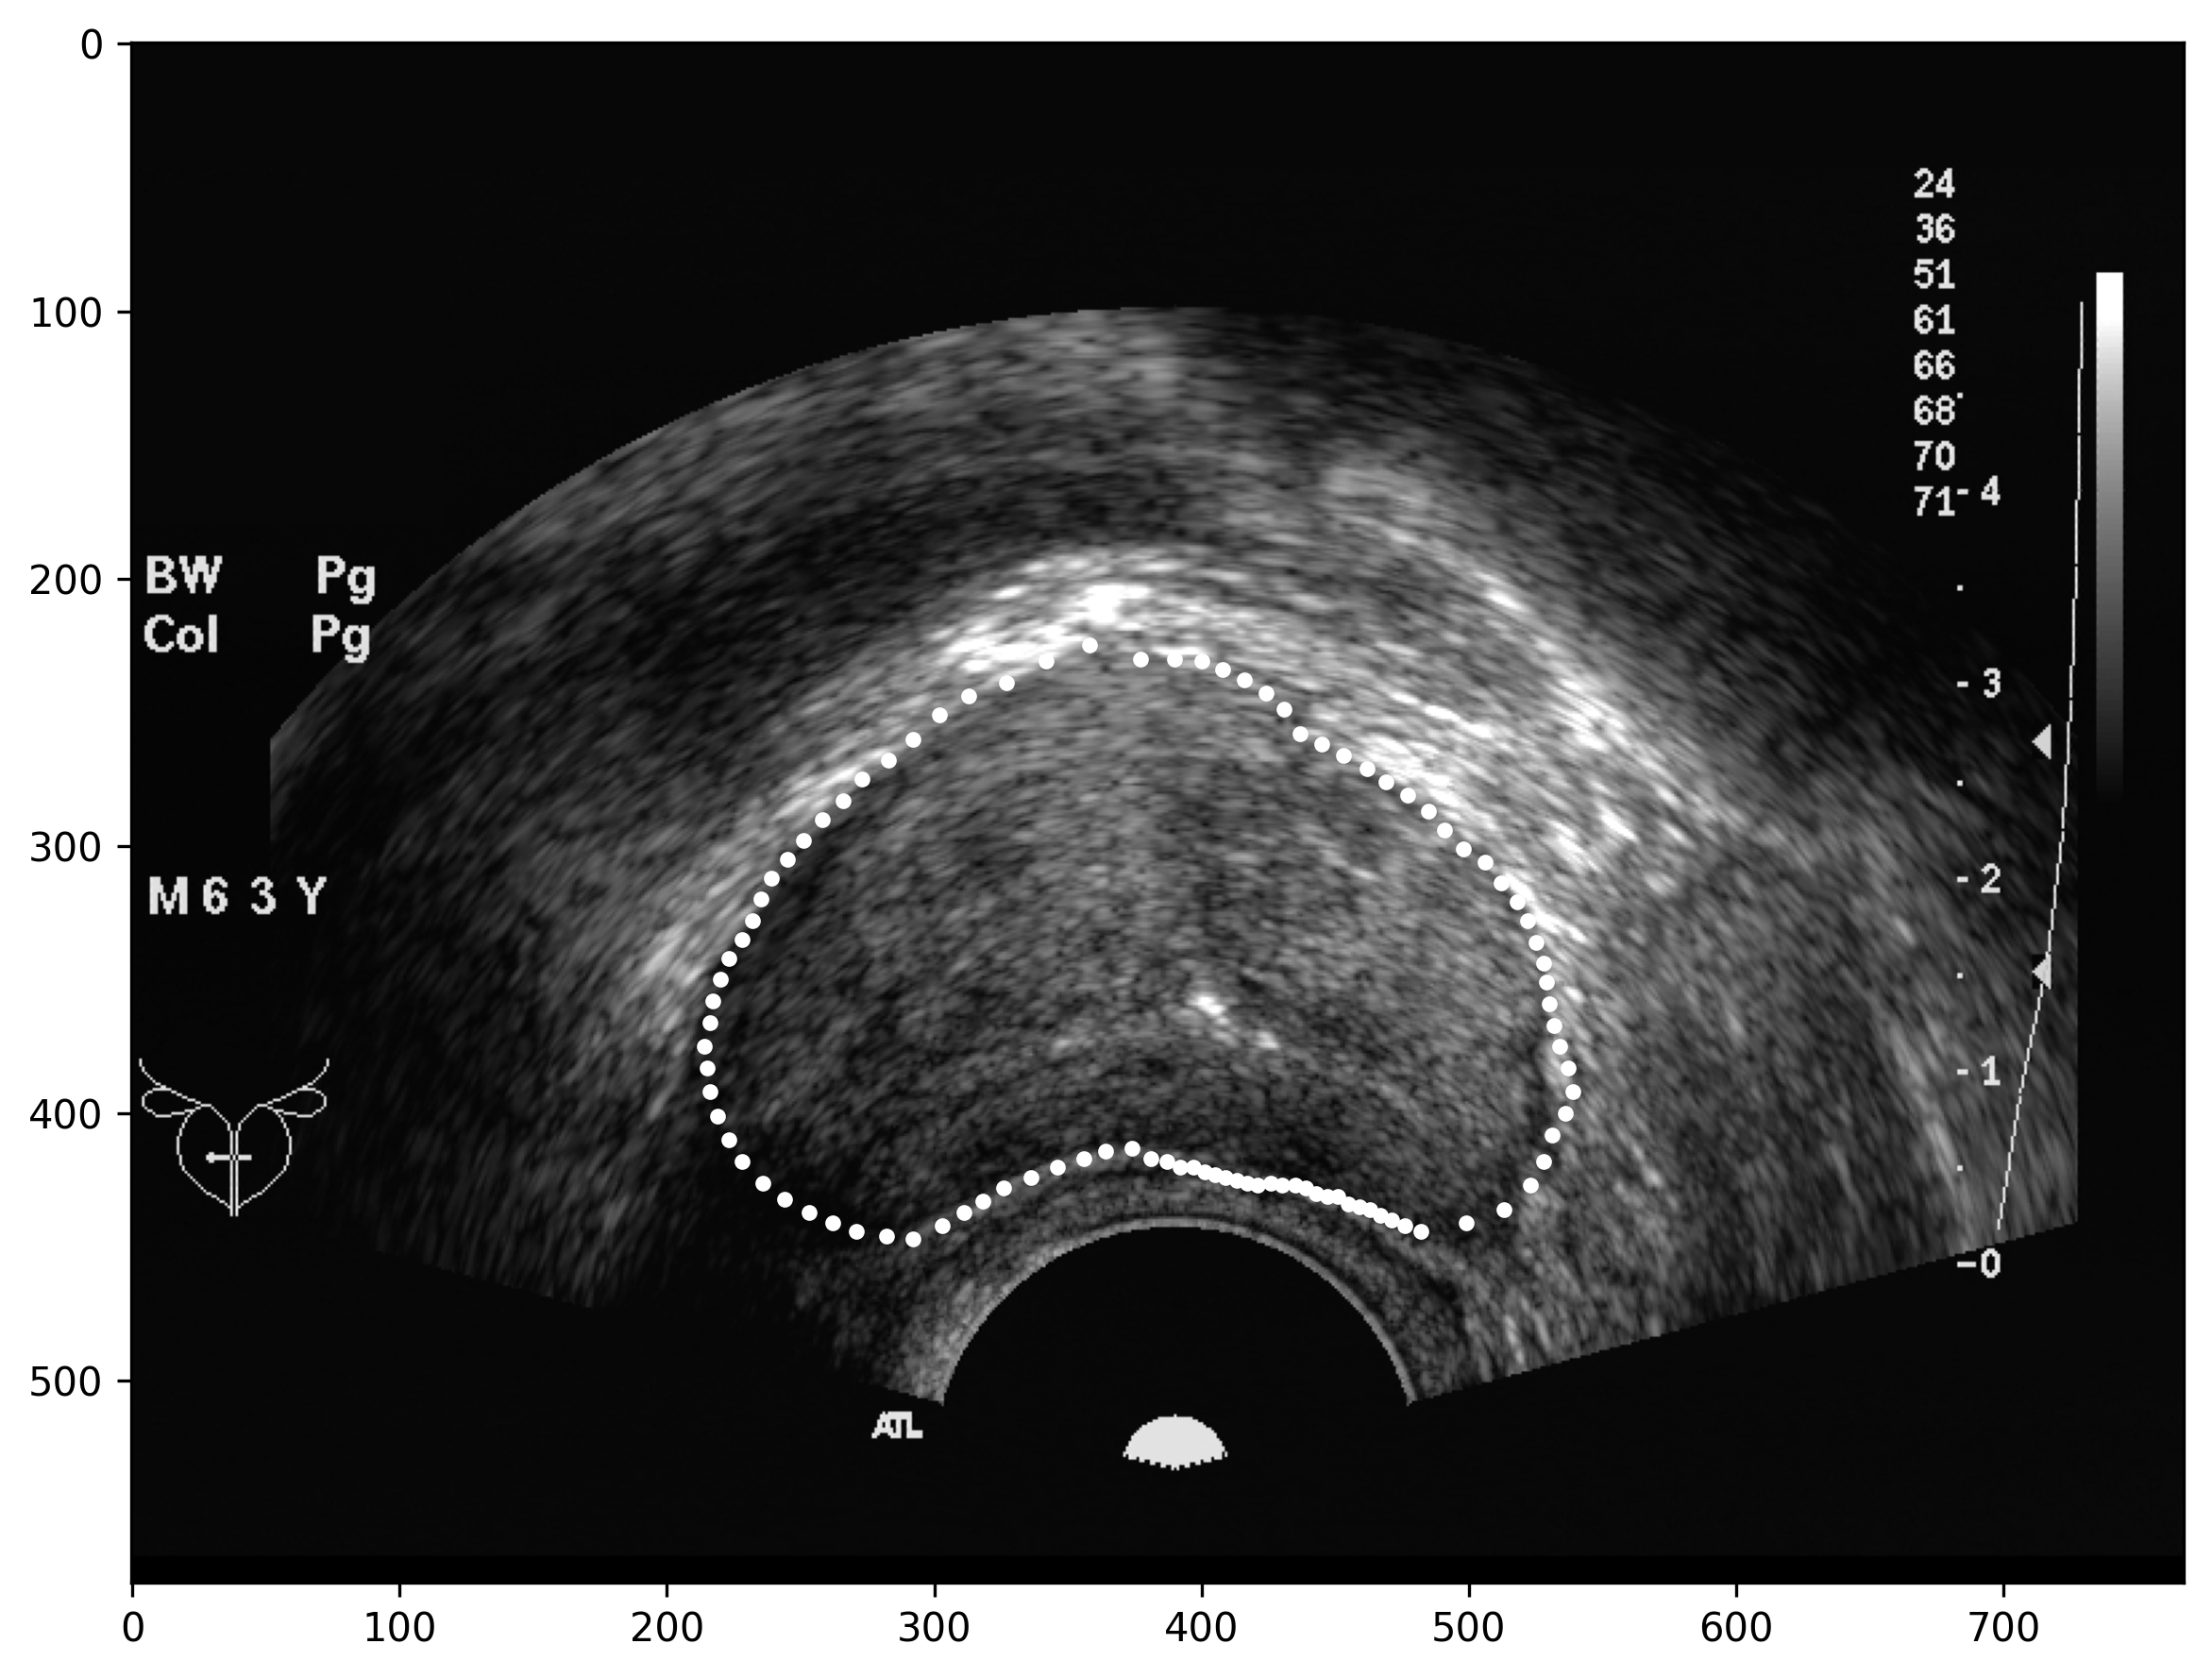

In [52]:
ema_rstp = []
#for i in range(1):
ema_ind = numpy.round(EMA(maxinds, period=5))
# ema_ind = numpy.round(EMA(ema_ind[::-1], period=5))
ema_ind = numpy.squeeze(numpy.array(ema_ind))
nan_idx = numpy.where(pandas.isnull(ema_ind))
ema_ind[nan_idx] = numpy.array(maxinds)[nan_idx]
ema_ind.astype(numpy.int16)
for i in range(100):
    ema_rstp.append(normpoints[i][ema_ind[i].astype(numpy.int0)+1+l,:])
ema_rstp = numpy.array(ema_rstp, dtype=numpy.int0)
print(ema_rstp.shape)
plt.figure(dpi=300)
plt.imshow(testimg,cmap='gray')
plt.plot(ema_rstp[:,0], ema_rstp[:,1],'w.')

(576, 768)


False

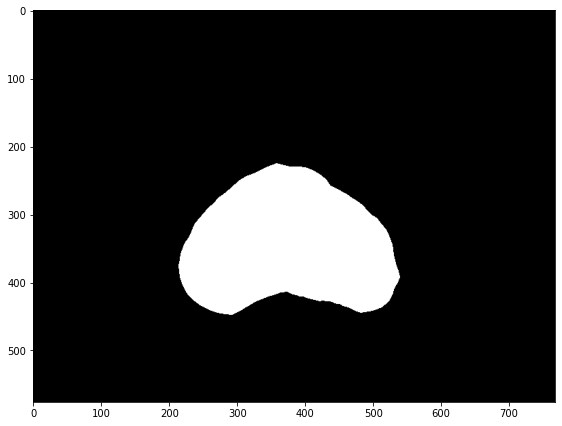

In [48]:
pseudo_label = numpy.zeros(testimg.shape)
cv2.fillPoly(pseudo_label, [ema_rstp], 255)
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.imshow(pseudo_label, cmap='gray')
print(pseudo_label.shape)
pp = pseudo_label[64:572, 128:648]
cv2.imwrite('pseudoLabel/7.png',pp)